In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
import math
import pandas as pd
from glob import glob
import pickle
import statsmodels.api as sm
from datetime import date
import numpy.linalg as LA


### Read data

In [2]:
File_dir='/Users/Jacob/Desktop/255/'
%cd $File_dir
#PD=pickle.load(open('DailyDiffs.pkl','rb'))
PD = pd.read_pickle('DailyDiffs.pkl')
Daily=PD['Daily']
Diffs=PD['Diffs']

/Users/Jacob/Desktop/255


### define class

In [3]:
class run_aver:
    ## Initialize the object
    def __init__(self,alpha=0.0):
        self.t = 0.0
        self.s = None
        self.alpha = alpha

    def send(self,x):
        if self.t==0:
            self.s=x
        elif self.alpha==0:
            self.s=(x + self.t*self.s)/(self.t+1.0)
        else:
            self.s=self.alpha*x + (1-self.alpha)*self.s                           
        self.t+=1.0
        residual=x-self.s
        return residual
    
    def get_state(self):
        return self.s

    def get_sqrt(self):
        return math.sqrt(self.s)
    
class run_Eigen:
    ## Initialize the object
    def __init__(self,alpha=0.0,beta=0.01):
        self.t = 0.0
        self.alpha=alpha
        self.beta=beta
        
    def send(self,x):
        if self.t==0:
            self.s=np.random.normal(x)
        else:
            s=self.s
            if self.alpha==0:
                s=s+(np.dot(s,x)*self.beta/math.sqrt(self.t))*x
            else:
                s=s+(np.dot(s,x)*self.alpha)*x
            Norm=LA.norm(s)
            if Norm>0: 
                s=s/Norm
            else:
                s=np.random.normal(x) 
            self.s=s
        self.t+=1.0
        
        dot=np.dot(self.s,x)
        residual=x-dot*self.s
        return residual
    
    def get_state(self):
        return self.s
    
    def get_var(self):
        return self.var.get_state()

### useful helper function

In [4]:
def one_step(x, av, eigenArr):
    r=av.send(x)
    sumi = r
    for j in range(len(eigenArr)):
        r=eigenArr[j].send(r)
        sumi += r
    return sumi
def saveEigen(eigenArr, storeArr):
    result = []
    for i in eigenArr:
        result.append(i.get_state())
    storeArr.append(result)
def projection(x, eigenVecs, numOfEigen):
    U = np.array(eigenVecs[:numOfEigen])
    return np.dot(U,x)

In [5]:
Diffs.head()

,AGN,EOG,WLP,CPB,YUM,JWN,TAP,BWA,WM,SPG,...,ICE,AN,HOT,ROK,TROW,ISRG,PFE,NKE,PFG,TSS
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
codes = list(Diffs.columns)
print codes
codes.index('C')

['AGN', 'EOG', 'WLP', 'CPB', 'YUM', 'JWN', 'TAP', 'BWA', 'WM', 'SPG', 'FIS', 'GT', 'GIS', 'MJN', 'ROP', 'GE', 'GD', 'VAR', 'AMZN', 'FII', 'MAS', 'MAR', 'MAT', 'SNA', 'SNI', 'XRAY', 'JNJ', 'XYL', 'TSN', 'TSO', 'BEN', 'CMI', 'DISCA', 'CMG', 'CME', 'DTE', 'PCL', 'CMS', 'DTV', 'VLO', 'HUM', 'APOL', 'LSI', 'PCLN', 'FSLR', 'HCP', 'IGT', 'K', 'FFIV', 'BLL', 'ORLY', 'BLK', 'FTI', 'HCN', 'NFX', 'MA', 'CBG', 'PRGO', 'MO', 'NOC', 'MU', 'CBS', 'NDAQ', 'SE', 'MS', 'TJX', 'NOV', 'AMGN', 'COST', 'FE', 'CTL', 'ADBE', 'DOV', 'DOW', 'MSFT', 'GLW', 'SCHW', 'BSX', 'FCX', 'SPLS', 'UPS', 'WHR', 'BBBY', 'MDT', 'F', 'DFS', 'CVS', 'JEC', 'V', 'FMC', 'AVY', 'ALL', 'NTAP', 'LMT', 'MMM', 'SO', 'JNPR', 'MMC', 'WEC', 'DPS', 'IBM', 'BAX', 'CAT', 'CAH', 'BAC', 'CAM', 'GS', 'AFL', 'CAG', 'LM', 'LH', 'HIG', 'CELG', 'A', 'ABC', 'ZION', 'STI', 'STJ', 'STT', 'ABT', 'XOM', 'STX', 'STZ', 'CFN', 'CERN', 'PNR', 'CMA', 'IVZ', 'LO', 'PNC', 'VFC', 'EIX', 'XLNX', 'AON', 'RAI', 'PRU', 'RF', 'RL', 'URBN', 'CHK', 'L', 'HRS', 'HRL', 

293

In [7]:
yearLength = int(len(Diffs['1962-01-01':'2015-01-01'])*1.0/(2015-1962))
#quarterLength = yearLength / 4
alpha = 1.0/(10*yearLength)
alpha

0.00039840637450199205

In [8]:
# calculate proper alpha value
#Diffs = Diffs.transpose()
#codes = Diffs.columns
Diffs = Diffs.reset_index()
Diffs = Diffs.fillna(0)

In [9]:
Diffs.head()

,Date,AGN,EOG,WLP,CPB,YUM,JWN,TAP,BWA,WM,...,ICE,AN,HOT,ROK,TROW,ISRG,PFE,NKE,PFG,TSS
0,1962-01-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1962-01-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1962-01-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1962-01-08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1962-01-09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### try to find optimal alpha

In [12]:
# do it PCA2
aa = 0.01
eigenNum = 20
storeArr = []
#eigenArr = [run_Eigen(aa,beta=0.1) for i in range(eigenNum)]
#Av=run_aver(alpha)
#i = 1
print "hello"
while aa < 0.1:
    r_sum = np.array([0]*481)
    Av=run_aver(0.0)
    eigenArr = [run_Eigen(aa,beta=0.1) for i in range(eigenNum)]
    i = 1
    while i < len(Diffs):
        #for code in codes:
        data = np.array(Diffs.ix[i][1:], dtype=np.float64)
        #print len(data)
        #print data
        r_sum += one_step(data, Av, eigenArr)
        #//if i%yearLength == 0:
            #//saveEigen(eigenArr, storeArr)
        i += 1
    print "========="
    print aa
    print LA.norm(r_sum)   
    aa += 0.01

hello
0.01
3.74165738677
0.02
4.0
0.03
3.87298334621
0.04
3.16227766017
0.05
3.87298334621
0.06
3.31662479036
0.07
3.0
0.08
4.24264068712
0.09
3.31662479036
0.1
3.74165738677


### store eigen vectors

In [10]:
aa = 0.07
eigenNum = 20
storeArr = []
eigenArr = [run_Eigen(aa,beta=0.1) for i in range(eigenNum)]
Av=run_aver(alpha)
i = 1
while i < len(Diffs):
    data = np.array(Diffs.ix[i][1:], dtype=np.float64)
    one_step(data, Av, eigenArr)
    if i%yearLength == 0:
        saveEigen(eigenArr, storeArr)
    i += 1

In [13]:
# find corresponding eigen vectors for 1970 and so on
index = [1970-1962, 1980-1962,1990-1962, 2000-1962, 2010-1962]
x = []
y = []
for i in index:
    #proj_points = projection(Diffs.ix[i*yearLength][1:], storeArr[i], 2)
    #x.append(proj_points[0]*storeArr[i][0]) 
    #y.append(proj_points[1]*storeArr[i][1])
    #print proj_points
    x.append(storeArr[i][0])
    y.append(storeArr[i][1])

# get sectors
constituents = pd.read_csv("constituents.csv", index_col="Symbol")
sectors = list(set(constituents[:]['Sector']))
# array of corrensponding sectors
cc = []
constiNameSet = set(constituents.index.values)
for code in codes:
    #if code in constiNameSet:
    cc.append( sectors.index(constituents.ix[code]['Sector']) )

In [12]:
sectors

['Industrials',
 'Telecommunication Services',
 'Consumer Discretionary',
 'Utilities',
 'Consumer Staples',
 'Health Care',
 'Materials',
 'Information Technology',
 'Energy',
 'Financials']

In [17]:
# 1970
xx = [[],[],[],[],[],[],[],[],[],[]]
yy = [[],[],[],[],[],[],[],[],[],[]]
textt = [[],[],[],[],[],[],[],[],[],[]]
for i in range(len(cc)):
    xx[cc[i]].append(x[0][i])
    yy[cc[i]].append(y[0][i])
    textt[cc[i]].append(codes[i])

In [20]:
import plotly.plotly as py
from plotly.graph_objs import *

def scatterInit(i, xx, yy, sectors, textt):
    return Scatter(
        x=xx[i],
        y=yy[i],
        mode='markers',
        name=sectors[i],
        text=textt[i],
        marker=Marker(
            #color=colorS,
            size=12,
            line=Line(
                color='white',
                width=0.5
            )
        )
    )
i = 0
dataa = []
while i < len(xx):
    dataa.append(scatterInit(i, xx, yy, sectors, textt))
    i += 1
layout = Layout(title='1970')
fig = Figure(data=Data(dataa), layout=layout)
py.iplot(fig, filename = '1970')

In [21]:
# 1980
xx = [[],[],[],[],[],[],[],[],[],[]]
yy = [[],[],[],[],[],[],[],[],[],[]]
textt = [[],[],[],[],[],[],[],[],[],[]]
for i in range(len(cc)):
    xx[cc[i]].append(x[1][i])
    yy[cc[i]].append(y[1][i])
    textt[cc[i]].append(codes[i])
i = 0
dataa = []
while i < len(xx):
    dataa.append(scatterInit(i, xx, yy, sectors, textt))
    i += 1
layout = Layout(title='1980')
fig = Figure(data=Data(dataa), layout=layout)
py.iplot(fig, filename = '1980')

In [22]:
# 1990
xx = [[],[],[],[],[],[],[],[],[],[]]
yy = [[],[],[],[],[],[],[],[],[],[]]
textt = [[],[],[],[],[],[],[],[],[],[]]
for i in range(len(cc)):
    xx[cc[i]].append(x[2][i])
    yy[cc[i]].append(y[2][i])
    textt[cc[i]].append(codes[i])
i = 0
dataa = []
while i < len(xx):
    dataa.append(scatterInit(i, xx, yy, sectors, textt))
    i += 1
layout = Layout(title='1990')
fig = Figure(data=Data(dataa), layout=layout)
py.iplot(fig, filename = '1990')

In [23]:
# 2000
xx = [[],[],[],[],[],[],[],[],[],[]]
yy = [[],[],[],[],[],[],[],[],[],[]]
textt = [[],[],[],[],[],[],[],[],[],[]]
for i in range(len(cc)):
    xx[cc[i]].append(x[3][i])
    yy[cc[i]].append(y[3][i])
    textt[cc[i]].append(codes[i])
i = 0
dataa = []
while i < len(xx):
    dataa.append(scatterInit(i, xx, yy, sectors, textt))
    i += 1
layout = Layout(title='2000')
fig = Figure(data=Data(dataa), layout=layout)
py.iplot(fig, filename = '2000')

In [24]:
# 2010
xx = [[],[],[],[],[],[],[],[],[],[]]
yy = [[],[],[],[],[],[],[],[],[],[]]
textt = [[],[],[],[],[],[],[],[],[],[]]
for i in range(len(cc)):
    xx[cc[i]].append(x[4][i])
    yy[cc[i]].append(y[4][i])
    textt[cc[i]].append(codes[i])
i = 0
dataa = []
while i < len(xx):
    dataa.append(scatterInit(i, xx, yy, sectors, textt))
    i += 1
layout = Layout(title='2010')
fig = Figure(data=Data(dataa), layout=layout)
py.iplot(fig, filename = '2010')

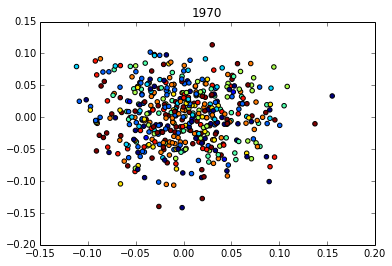

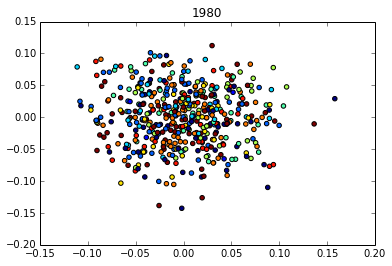

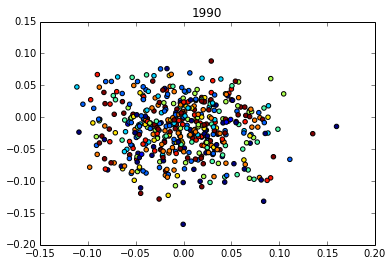

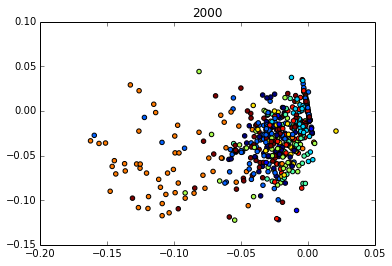

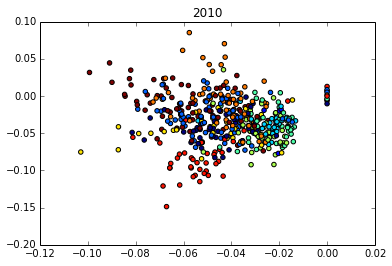

In [24]:
years = np.arange(1970, 2020, 10)
for i in range(len(years)):
    plt.figure(i)
    plt.scatter(x[i],y[i],c=cc)
    plt.title(years[i])

## Local Analysis

### Top 10 nearest companies in all time

In [27]:
Diffs=PD['Diffs']

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
diffs_matrix=np.transpose(np.array(Diffs.fillna(0)))
pca.fit(diffs_matrix)
eigen_vecs=pca.components_
len(eigen_vecs)

20

In [51]:
X = np.dot(eigen_vecs, diffs_matrix.transpose())
X.shape

(20, 481)

In [52]:
from sklearn.neighbors import KDTree
X = X.transpose()
tree = KDTree(X)
dist, ind = tree.query(X[codes.index('C')], k=11) 
ind

array([[293, 104, 443, 157, 373, 350,  64, 116, 210, 129, 209]])

Ten closest companies in all time span to citi group are
C
BAC
JPM
WFC
BK
AIG
MS
STI
KEY
PNC
LNC


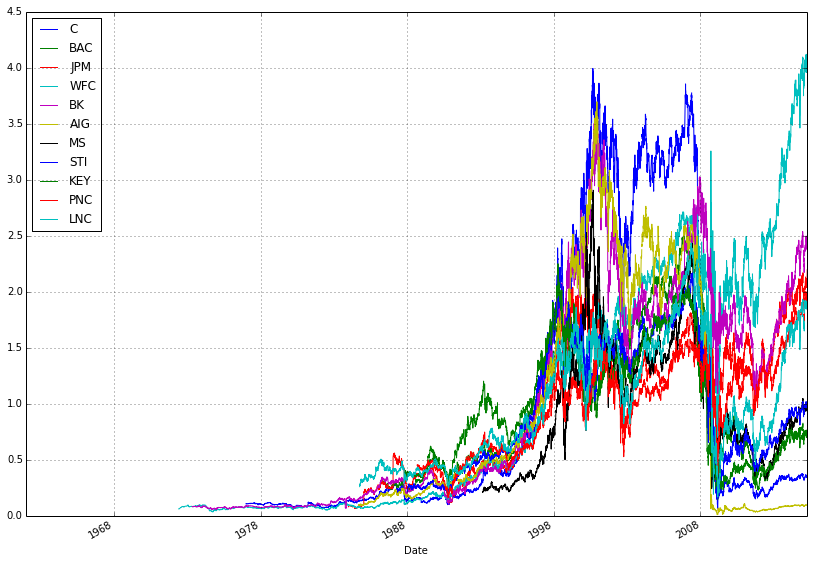

In [54]:
print "Ten closest companies in all time span to citi group are"
cc = []
for i in ind[0]:
    cc.append(codes[i])
    print codes[i]
Daily[cc].plot(figsize=(14,10))

### Top 10 closest companies in different decades

Ten closest companies in 1970 to citi group are
C
CLF
DISCA
OMC
INTC
SE
ANF
CTL
IFF
PAYX
CHRW
Ten closest companies in 1980 to citi group are
C
DISCA
CLF
OMC
INTC
SE
ANF
CTL
IFF
PAYX
PEP
Ten closest companies in 1990 to citi group are
C
INTC
CLF
DISCA
PEP
IFF
SWK
CVS
HSY
SE
CTL
Ten closest companies in 2000 to citi group are
C
CLF
INTC
OMC
CVS
HD
IFF
SWK
BAC
STI
PEP
Ten closest companies in 2010 to citi group are
C
DISCA
DOW
EQR
TRV
CBG
OMC
CHRW
JCI
WYN
UTX


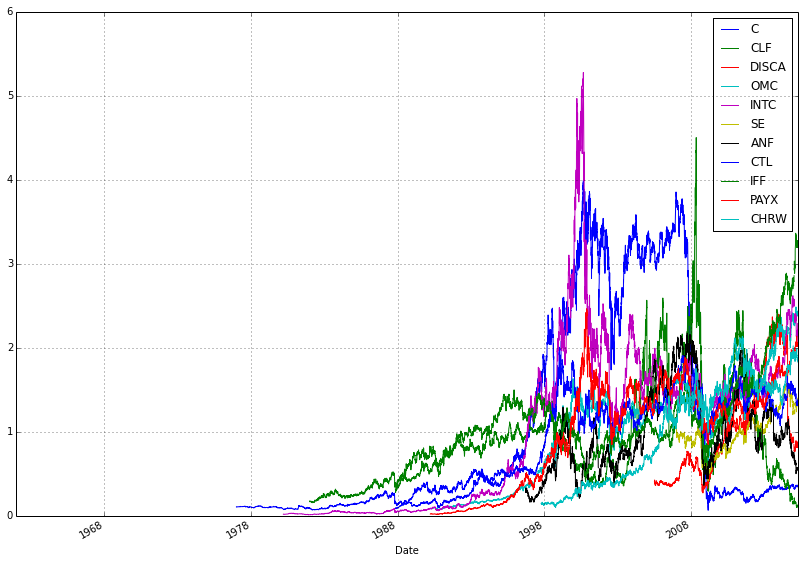

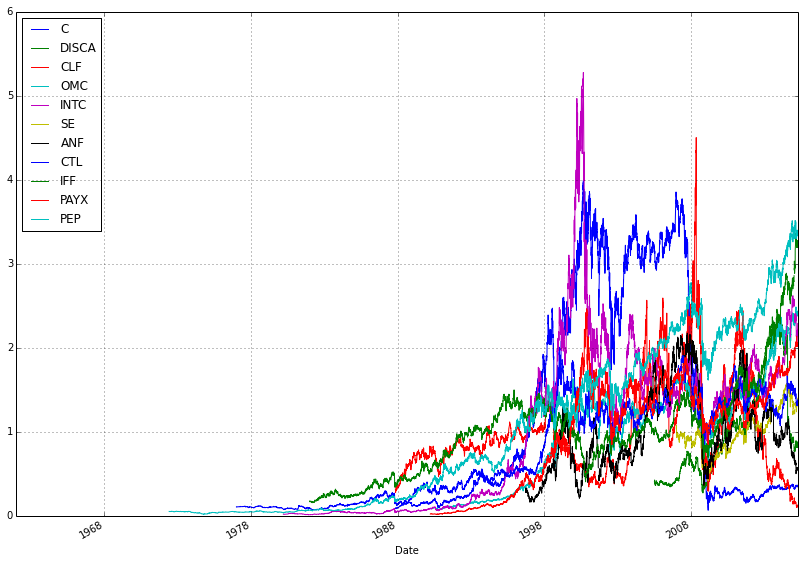

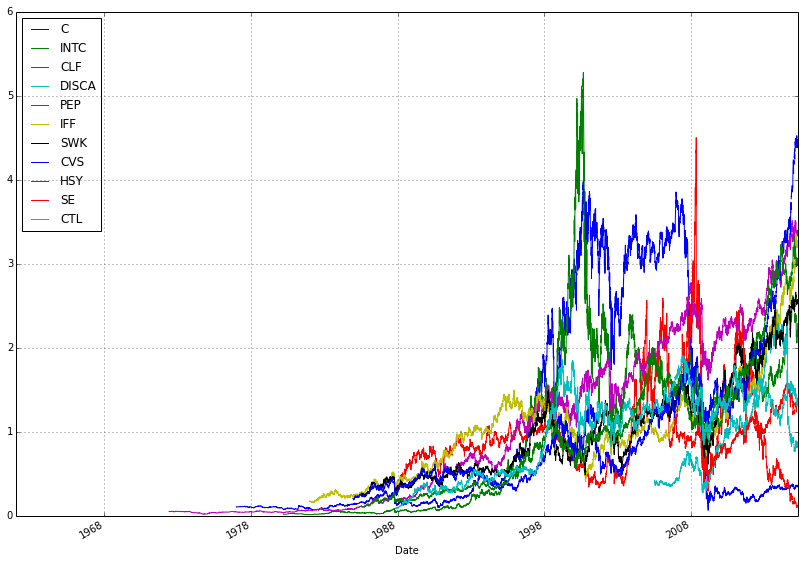

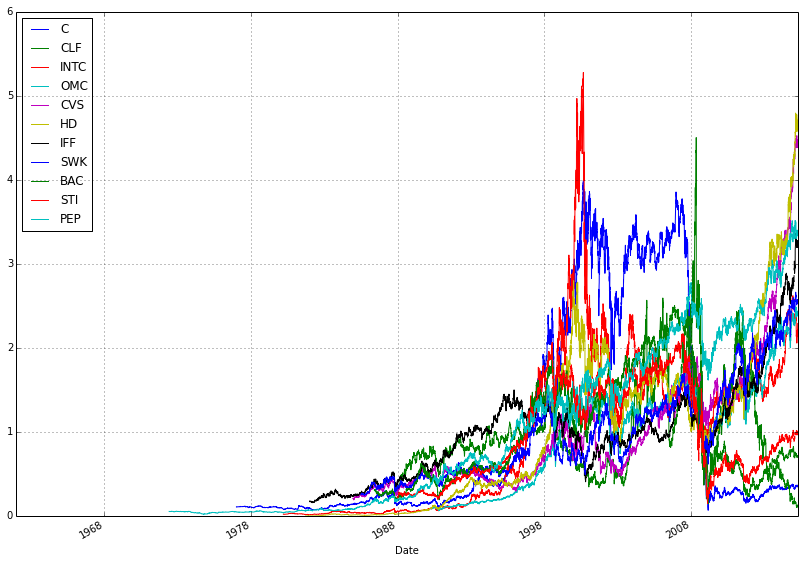

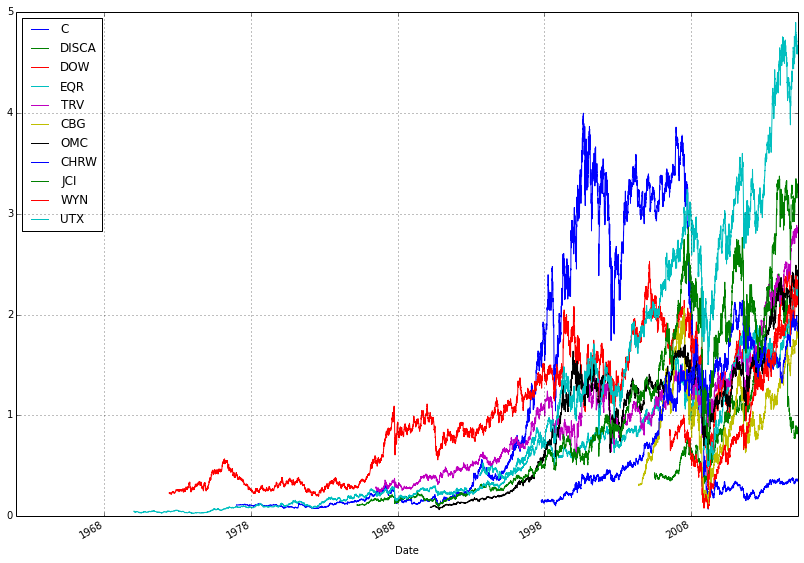

In [55]:
index = [1970-1962, 1980-1962,1990-1962, 2000-1962, 2010-1962]
years = np.arange(1970, 2020, 10)
j = 0
for i in index:
    com = []
    X = np.array(storeArr[i]).transpose()
    tree = KDTree(X)
    dist, ind = tree.query(X[codes.index('C')], k=11)
    print "Ten closest companies in {} to citi group are".format(years[j])
    for i in ind[0]:
        com.append(codes[i])
        print codes[i]
    Daily[com].plot(figsize=(14,10))
    j += 1

####Neighbors: DISCA(Discovery Communications Inc.), CLF(Cliffs Natural Resources Inc), OMC(Omnicom Group), INTC(Intel Corporation), SE(Spectra Energy), ANF(Abercrombie & Fitch), CTL(CenturyLink), IFF(International Flavors & Fragrances Inc), PAYX(Paychex ), PEP(PepsiCo ); SWK(Stanley Black & Decker, Inc.), CVS(CVS Health), HSY(The Hershey Company); HD(The Home Depot), BAC(Bank of America), STI(SunTrust Banks); DOW(Dow Chemical Company), EQR(Equity Residential), TRV(The Travelers Companies), CBG(CBRE Group), CHRW(C. H. Robinson Worldwide), JCI(Johnson Controls), WYN(Wyndham Worldwide Corp), UTX(United Technologies Corporation)

### Citi group is quite distinct from its neighbors in terms of the functionalities among them. In the first three decades, most of the neighbors do business quite unrelated to citi. Some of them are media, some of them provide food, clothes and energy. One company worth noting is OMC, the Omnicom Group, because it provided advertising service for citi. Another is DISCA, Discovery Communications Inc, whose stock share is partially owned by citi; this company appear in nearly every decade as a neighbor. Yet another is PAYX, Paychex, who supplied service to citi as Citi Business Payroll Management, which serves small business payroll.
### In later two decades, the graph seems more organized and two competitors are observed: BAC(Bank of America) and STI(Sun Trust Banks). One company worth noting is TRV, The Travelers Companies. This company merged with Citi Corp to form today's Citi Inc, so its appearance in the 2010 graph is not a coincidence since the merge took place in the decade. Another relevant company is UTX, United Technologies Corporation, and Citi bought some shares of this company in the near decade.
### The functionalities of the neighboring companies shifted from those providing direct products such as food, furniture and clothes to those who provide service. Such might indicate a shift of citi's focus on different companies as time move on.

### Extra credit 2.
### Adjusted means the calculation of stock price has taken into account factors of non supply-demand such as adjusting for splits and dividends. They would be better for analyzing PCA since they would reflect how well the stock performs in spit of splits, for example, on Wednesday, Stock X closed at 40 per share. On Thursday, a two-for-one stock split went into effect; Stock X opened at 20 and closed at 21, up 1. The actual closing price would deceivingly indicate a 19 decline (40-21). However, the adjusted close for Wednesday would change to 20, and the adjusted close for Thursday of 21 shows the actual 1 gain in the share price. Since the adjusted column reveals how well the stock really performs, they are better for PCA.